# 08.3 Workshop on the Empirical evaluation of computational complexity

```
date: "Block 08"
author: "Daniel Lawson"
email: dan.lawson@bristol.ac.uk
output: html_document
version: 2.0.0
```

0. Introduction

This workshop is about understanding computational complexity and exploring how to display this in python.

The source ideas for this workshop were inspired by
<https://towardsdatascience.com/understanding-time-complexity-with-python-examples-2bda6e8158a7>, though the implementations vary from that.

We will use the standard conventions for time complexity, i.e.

* $O(n)$ means that the maximum run time is bounded by a linear function in $n$

The algorithms below are close to deterministic. However, some algorithms vary in **Amortized** time, or in **average case** complexity. Repeating the analysis below with carefully chosen functions to demonstrate the different scaling would be very valuable.

In general, the distinction between worst-case and typical-case is important:

* if an algorithm may be run over most potential inputs, 
* if these might be chosen adversarially, or 
* if benchmarking of an algorithm is done for a rather different section of input space to where it might be deployed. 

The run time, and the memory requirement scaling are two of the most important quantities. Memory requirements are usually (but not always) easily bounded and few algorithms have massive variation in memory requirement (it is an undesirable feature for e.g. parallelisation).

### Technical note:

There is a tradeoff in making self-contained code, and correctly benchmarked code, which arises because of the need to generate data for the algorithms below. Rather than generate data externally we have elected to do it within the timing loop. 

Data generation is an $O(N)$ activity. This breaks some of the asymptotics, as generating data plus searching it using a logarithmic algorithm is asymptotically dominated by the generation time. However, the constants are sufficiently different that for the scale of experiments perfomed here, the search cost dominates and we see the correct behaviour!

This is an important lesson in the difference between theory and practice. Constants do matter.

## 0.1 Required packages

In [1]:
!pip install matplotlib numpy

In [2]:
#!pip install pipreqsnb
!pipreqsnb --savepath requirements-block09.txt block09-TimeComplexity.ipynb

pipreqs  --savepath requirements-block09.txt /Users/madjl/teach/dst-private/Workshops/__temp_pipreqsnb_folder
INFO: Successfully saved requirements file in requirements-block09.txt


In [3]:
print("\nREQUIREMENTS:\n")
with open('requirements-block09.txt', 'r') as f:
    print(f.read())


REQUIREMENTS:

matplotlib==3.6.0
numpy==1.24.4



In [4]:
from math import * # For log, etc
from timeit import Timer ## For timing 
from functools import partial ## For passing functions to be evaluated with arguments
import random ## For permutations
import numpy as np ## For numpy arrays for passing to:
import matplotlib.pyplot as plt ## For plotting with pylot
%matplotlib notebook

## Constant time complexity

A traditional constant time complexity algorithm is the "head" function, ie. to get the first M records of a dataset.

We won't benchmark this because it is not interesting.

## Logarithmic time complexity

The binary search algorithm is textbook as it is easily identified as logarithmic time complexity, because it splits the space into two equal parts at each iteration and therefore makes the surviving space "exponentially small".

Note that we define two versions of the algorithm, the "real version" which must be provided arguments, and a "randomised version" that just requires a data size, for benchmarking. See the technical note above regarding the cost of data generation.

In [5]:
## Logarithmic time algorithm
def binary_search(data, value): 
    ## Finds the index of the data that matches the value
    ## data must be sorted
    n = len(data)
    left = 0
    right = n - 1

    while left <= right:
        middle = floor((left + right) / 2)
        if value < data[middle]:
            right = middle - 1
        elif value > data[middle]:
            left = middle + 1
        else:
            return(middle)
    raise ValueError('Value is not in the list')

def r_binary_search(datalen):
    data=range(datalen)
    value=random.choice(data)
    return(binary_search(data,value))


In [6]:
## An example of using binary search
data = [1, 2, 3, 4, 5, 6, 7, 8, 9]
print(binary_search(data,5))

4


### Writing a timing function

Python has many ways to access the time before and after an evaluation. However the "Timer" function is the easiest to  work with in this context as it does the handling for us. See e.g. https://realpython.com/python-timer/ for many more options.

In [7]:
def time_fun(fun,l,rep=100):
    t=Timer(partial(fun,l))
    return([l,t.timeit(rep)/rep])

In [8]:
#?Timer

## Linear time complexity - linear search

This is even simpler - we just look through the whole list for a particular item. Obviously a poor choice but occasionally makes sense if the data are not sorted or pre-prepared in any way.

In [9]:
## Linear time
def linear_search(data, value):
    for index in range(len(data)):
        if value == data[index]:
            return index
    raise ValueError('Value not found in the list')

def r_linear_search(datalen):
    data=range(datalen)
    value=random.choice(data)
    return(linear_search(data,value))

In [10]:
## An example of using linear search
data = [1, 2, 3, 4, 50, 6, 7, 8, 9]
print(linear_search(data,50))

4


## Quasilinear time algorithm: append with a lookup

Quasilinear means "linear, to logarithmic factors". So $O(N log(N)^x)$ for any fixed $x$ all count.

Quasilinear is often the gold-standard, because it allows you to a) look at all your data, and b) do something non-trivial with it. In high-throughput environments such as streaming, or will very large datasets, this can still be a problem; but the logarithmic term is usually on the same scale as a constant so beware the time complexity argument for superiority.

Here we just do a simple lookup for each item, trivially creating a quasilinear algorithm. [Merge sort](https://en.wikipedia.org/wiki/Merge_sort) is another famous example of such an algorithm.

In [11]:
## Quasilinear time: O(nlog(n))
def quasilinear_lookup(data1,data2):
    ## For each entry in data1, look up the index in data2 using binary search
    ## data2 must therefore be sorted
    result=[]
    for value in data1:
        result.append(binary_search(data2, value))
    return(result)

def r_quasilinear_lookup(datalen):
    data1=np.random.permutation(datalen)
    data2=range(datalen)
    return(quasilinear_lookup(data1,data2))

In [12]:
## An example of using quasilinear_lookup
quasilinear_lookup([0,40,20,10,30],[0,10,20,30,40])

[0, 4, 2, 1, 3]

## Quadratic time: bubble sort

Quadratic time is another key complexity milestone. It essentially arises out of double loops or "all-vs-all" comparisons.

[Bubble sort](https://en.wikipedia.org/wiki/Bubble_sort) is a classic example since it compares every item to half of the others, on average (and in the worst case).

In [13]:
## Quadratic time
def bubble_sort(data):
    swapped = True
    while swapped:
        swapped = False
        for i in range(len(data)-1):
            if data[i] > data[i+1]:
                data[i], data[i+1] = data[i+1], data[i]
                swapped = True
    return(data)

def r_bubble_sort(datalen):
    data=np.random.permutation(datalen)
    return(bubble_sort(data))

## Exponential time

You basically never want to use an exponential time algorithm unless the exponent is controlled. Brute-force password hacks are exponential time which is why long passwords are required; an additional character creates a huge additional bonus. ($26^n$ for lowercase characters of length $n$).

This example is a recursive algorithm for calculating the Fibonacci sequence. It is rather artificial as there are better ways, calculating them as an actual sequence, or using lookups. But its useful for illustration. It generates an exponential cost by computing the Fibonacci number as a computational tree with $O(2^n)$ nodes.

In [14]:
## Exponential time
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)


In [15]:
## Usage is rather simple
fibonacci(10)

55

## Factorial time

It will rarely be helpful to contemplate the difference between exponential and factorial time, but $n!$ grows larger than $2^n$. There are $n!$ permutations so computing these is the classic algorithm for illustration. We do occasionally do this, and we often want to sample such permutations, and/or know when to switch between exhaustive search and sampling.

In [16]:
## https://www.geeksforgeeks.org/generate-all-the-permutation-of-a-list-in-python/

# Python function to print permutations of a given list 
def permutation(lst): 
    # If lst is empty then there are no permutations 
    if len(lst) == 0: 
        return [] 
    # If there is only one element in lst then, only 
    # one permuatation is possible 
    if len(lst) == 1: 
        return [lst] 
    # Find the permutations for lst if there are 
    # more than 1 characters 
  
    l = [] # empty list that will store current permutation 
    # Iterate the input(lst) and calculate the permutation 
    for i in range(len(lst)): 
       m = lst[i] 
       # Extract lst[i] or m from the list.  remLst is 
       # remaining list 
       remLst = lst[:i] + lst[i+1:] 
  
       # Generating all permutations where m is first 
       # element 
       for p in permutation(remLst): 
           l.append([m] + p) 
    return l 

def r_permutation(len): 
    data = list(range(len))         
    permutation(data)

In [17]:
## Getting the results
data = list(range(4))         
permutation(data)

[[0, 1, 2, 3],
 [0, 1, 3, 2],
 [0, 2, 1, 3],
 [0, 2, 3, 1],
 [0, 3, 1, 2],
 [0, 3, 2, 1],
 [1, 0, 2, 3],
 [1, 0, 3, 2],
 [1, 2, 0, 3],
 [1, 2, 3, 0],
 [1, 3, 0, 2],
 [1, 3, 2, 0],
 [2, 0, 1, 3],
 [2, 0, 3, 1],
 [2, 1, 0, 3],
 [2, 1, 3, 0],
 [2, 3, 0, 1],
 [2, 3, 1, 0],
 [3, 0, 1, 2],
 [3, 0, 2, 1],
 [3, 1, 0, 2],
 [3, 1, 2, 0],
 [3, 2, 0, 1],
 [3, 2, 1, 0]]

## Benchmarking the algorithms

Now we run each algorithm at a suitably chosen range of inputs.

Note the value in coercing to a numpy array so that we can slice the results "the other way". Note also that we retain both the size of the data to be processed, and the time cost of the run.

In [18]:
binary_times=np.array(
    [time_fun(r_binary_search,floor(t)) for t in [1e0,1e1,1e2,1e3,1e4,1e5,1e6]]
)


In [19]:
quasilinear_times=np.array(
    [time_fun(r_quasilinear_lookup,floor(t)) for t in [1e0,1e1,1e2,1e3,1e4,2e4,3e4]]
)

In [20]:

linear_times=np.array(
    [time_fun(r_linear_search,floor(t)) for t in [1e0,1e1,1e2,1e3,1e4,1e5,1e6]]
)

In [21]:
bubblesort_times=np.array(
    [time_fun(r_bubble_sort,floor(t)) for t in [1e0,1e1,1e2,1e3]]
)


In [22]:
fibonacci_times=np.array(
    [time_fun(fibonacci,floor(t),rep=1) for t in [1,2,5,10,15,20,25,30,32,34,36,38]]
)


In [23]:
factorial_times=np.array(
    [time_fun(r_permutation,floor(t),rep=1) for t in [1,2,5,6,7,8,9,10]]
)

In [24]:
linear_times

array([[1.00000000e+00, 3.26916052e-06],
       [1.00000000e+01, 1.33458001e-06],
       [1.00000000e+02, 4.16708994e-06],
       [1.00000000e+03, 3.49541701e-05],
       [1.00000000e+04, 3.21108340e-04],
       [1.00000000e+05, 3.22350917e-03],
       [1.00000000e+06, 3.24757996e-02]])

## Plotting

Note that we standardize each dataset to start at $(1,1)$ so that any constant factors are stored similarly. This isn't perfect but it helps show the trend, separately from the base cost.

<IPython.core.display.Javascript object>


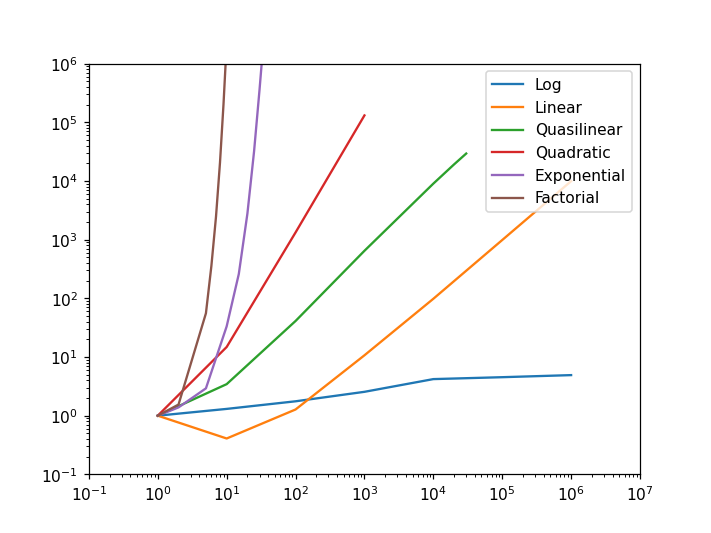

In [25]:
plt.plot(binary_times[:,0]/binary_times[0,0],
         binary_times[:,1]/binary_times[0,1])
plt.plot(linear_times[:,0]/linear_times[0,0],
         linear_times[:,1]/linear_times[0,1])
plt.plot(quasilinear_times[:,0]/quasilinear_times[0,0],
         quasilinear_times[:,1]/quasilinear_times[0,1])
plt.plot(bubblesort_times[:,0]/bubblesort_times[0,0],
         bubblesort_times[:,1]/bubblesort_times[0,1])
plt.plot(fibonacci_times[:,0]/fibonacci_times[0,0],
         fibonacci_times[:,1]/fibonacci_times[0,1])
plt.plot(factorial_times[:,0]/factorial_times[0,0],
         factorial_times[:,1]/factorial_times[0,1])
plt.axis([.1, 1e7, .1, 1e6])
plt.xscale('log')
plt.yscale('log')
plt.legend(['Log','Linear','Quasilinear','Quadratic','Exponential','Factorial'])
plt.show()

## Final thoughts

Even with these simple functions, there are deviations from the theoretical time complexity. What can cause this?

* Memory paging
* CPU load/ Background processes
* Algorithmic non-triviality (amortization?)
* Any more?

Can you benchmark your own code as a function of data input size? Can you think of examples where runtime does not depend trivially on input size, or can even decrease at some sizes?

A question... how would you compute space/memory usage in real processes? Can you do this? 

* In Python, check out a [memory profiler](https://pypi.org/project/memory-profiler/).
* Notice that you have to call python separately for each of these requests. Why is that?
 
Now we've seen this content, it would be interesting to consider it as a component of an Assessment. 

* In Data Science, we often have multiple input scaling, e.g. data count, feature size, data variability can all affect runtime.
* Can you benchmark a set of non-trivial algorithms? How do they behave as a function of the input shape? 